# Support Vector Machine (a.k.a. Large Margin Classification)

<img src="machine-learning-inside.gif" />

## Boring stuff ... installing packages, importing things, fixing the world

In [1]:
!pip install plotly

In [2]:
# importing required modules
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import scipy.optimize
import sklearn.svm
import sklearn.datasets
import sklearn.model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

# some high DPI settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Error Analysis

* Compute errors
    * `classifier.score()`
    * Precision, Recall, F-score
    * Cross-Validation error, Training error (with `.score()`)
* DONE: Training set generator v2
* Regularization: fix over-/underfitting by choosing $C$ or $\lambda$
    * Cost function: explain what different values of $C$ achieve
    * overfitting: too many features, fails to generalize
* Learning curves
    * decide if more training data makes predictions better
    * plots for high bias/high variance (see Xournal)
    * extrapolation
* Parameters of other kernels (RBF: gamma?)
* Correlation

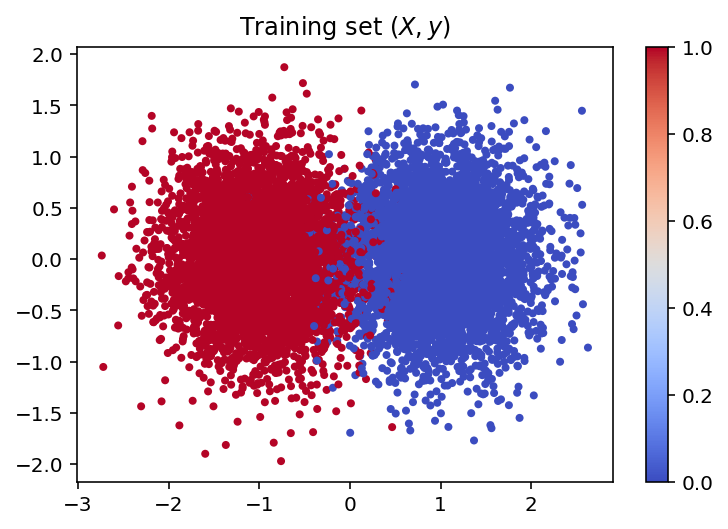

In [41]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 10000
half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,   # first half of the training set
    np.array(gaussian2d(-1, 0, sigma, half_m)).T   # second half of the training set
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m), # setting results to 0
    np.repeat(1, half_m)  # setting results to 1
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

# permutate X and y with P
X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker=".")
plt.colorbar()
plt.title("Training set $(X, y)$")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 2), (3000, 2), (7000,), (3000,))

## Regularization

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T f^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T f^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

Simplified:

$$ \min_{\theta} J\big(\theta\big) = \min_{\theta} C \cdot \theta \cdot x + \Vert\theta\Vert^2$$

* high $C$ $\rightarrow$ low $\theta$ (prone to underfitting)
* low $C$ $\rightarrow$ high $\theta$ (prone to overfitting)

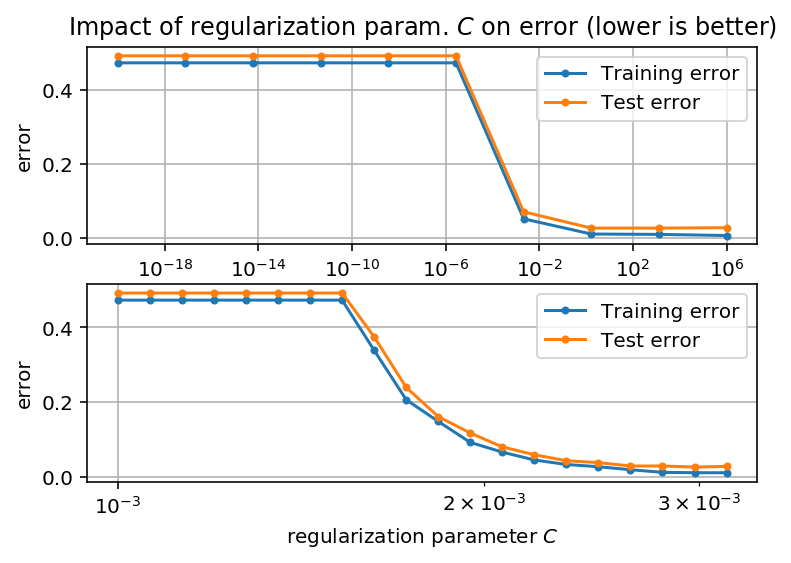

In [5]:
cc = np.logspace(start=-20, stop=6, num=10, base=10)
training_error = []
test_error = []
regularization_classifier = sklearn.svm.SVC(kernel="rbf")
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 1)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.title("Impact of regularization param. $C$ on error (lower is better)")
plt.ylabel("error")
plt.grid()

cc = np.logspace(start=-3, stop=-2.5, num=20, base=10)
training_error = []
test_error = []
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 2)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.xlabel("regularization parameter $C$")
plt.ylabel("error")
plt.grid()

plt.show()

Gaussian-hill, low $C$ reduces the hill, at some $C$ all points are in the same set, 50% error

In [11]:
cc = np.logspace(start=-6, stop=5, num=20, base=10) # TODO: stop=6
sizes = np.logspace(start=1, stop=3.845, num=20, base=10)
xx, yy = np.meshgrid(cc, sizes)
m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ xx.ravel(), yy.ravel() ]

size_classifier = sklearn.svm.SVC(kernel="rbf")

def error(C, size):
    size = int(size)
    size_classifier.set_params(C=C)
    size_classifier.fit(X_train[:size], y_train[:size])
    training_error = 1 - size_classifier.score(X_train[:size], y_train[:size])
    test_error = 1 - size_classifier.score(X_test, y_test)
    return (training_error, test_error)

Z = np.apply_along_axis(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)

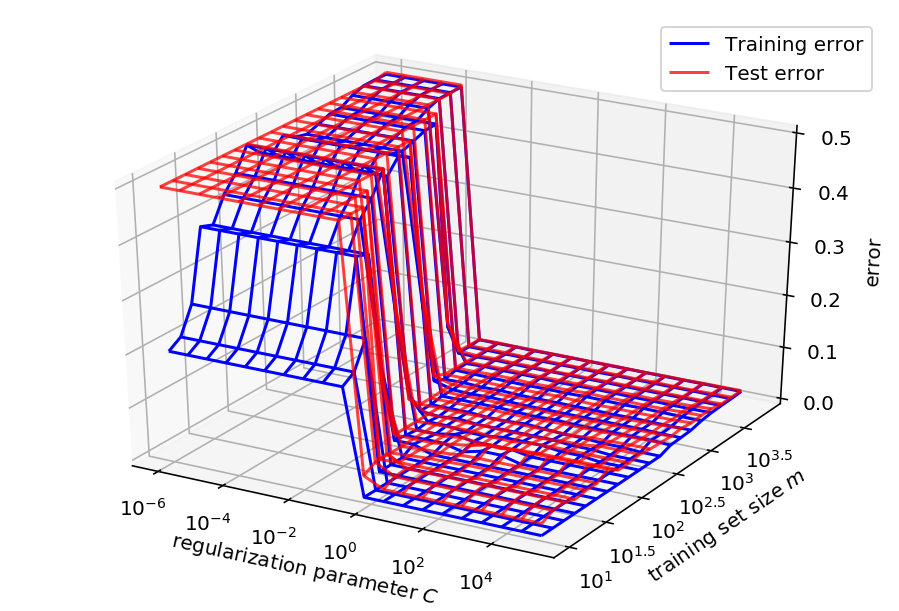

In [7]:
fig = plt.figure()
ax = Axes3D(fig)

ax.plot_wireframe(np.log10(xx), np.log10(yy), Z[:, 0].reshape(xx.shape), label="Training error", color="blue", alpha=1)
ax.plot_wireframe(np.log10(xx), np.log10(yy), Z[:, 1].reshape(xx.shape), label="Test error", color="red", alpha=0.75)

def log_tick_formatter(val, pos=None):
    return "$10^{%g}$" % val

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("regularization parameter $C$")
ax.set_ylabel("training set size $m$")
ax.set_zlabel("error")
ax.legend()

plt.show()

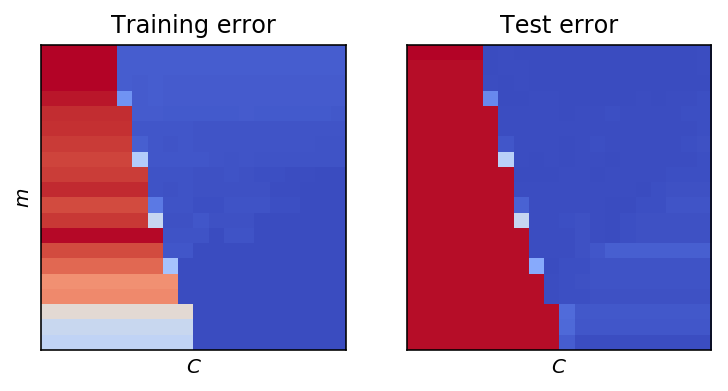

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(np.flip(Z[:, 0].reshape(xx.shape), 0), cmap=plt.cm.coolwarm)
plt.title("Training error")
plt.xlabel("$C$")
plt.ylabel("$m$")
plt.xticks([], [])
plt.yticks([], [])
plt.subplot(1, 2, 2)
plt.imshow(np.flip(Z[:, 1].reshape(xx.shape), 0), cmap=plt.cm.coolwarm)
plt.title("Test error")
plt.xlabel("$C$")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

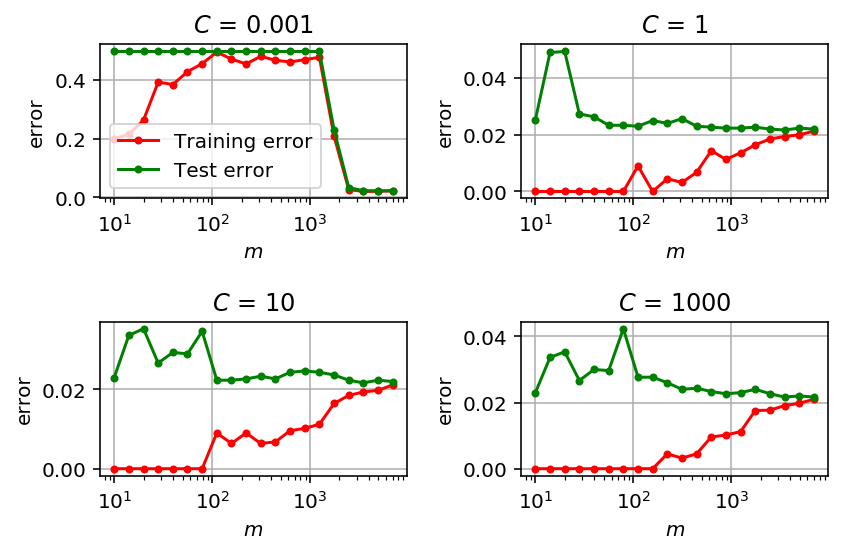

In [38]:
sizes = np.logspace(start=1, stop=3.845, num=20, base=10)
cc = [ 0.001, 1, 10, 1000 ]

training_error = []
test_error = []

for C in cc:
    for size in sizes:
        size = int(size)
        size_classifier.set_params(C=C)
        size_classifier.fit(X_train[:size], y_train[:size])
        training_error.append(1 - size_classifier.score(X_train[:size], y_train[:size]))
        test_error.append(1 - size_classifier.score(X_test, y_test))

for i, C in enumerate(cc):
    plt.subplot(2, 2, i + 1)
    plt.semilogx(sizes,
        training_error[(len(sizes) * i):(len(sizes) * (i + 1))],
        label="Training error", marker=".", color="r")
    plt.semilogx(sizes,
        test_error[(len(sizes) * i):(len(sizes) * (i + 1))],
        label="Test error", marker=".", color="g")
    if i == 0:
        plt.legend()
    plt.grid()
    plt.ylabel("error")
    plt.xlabel("$m$")
    plt.title("$C$ = %g" % C)

plt.tight_layout()
plt.show()

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f7bd6df2c00, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f7bd6df2c00, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 24, 21, 4, 53, 711265, tzinfo=tzlocal()), 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'session': '84857B5031EC4EF68180E4E8E78F93C5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'84857B5031EC4EF68180E4E8E78F93C5']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 24, 21, 4, 53, 711265, tzinfo=tzlocal()), 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'session': '84857B5031EC4EF68180E4E8E78F93C5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'84857B5031EC4EF68180E4E8E78F93C5'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 24, 21, 4, 53, 711265, tzinfo=tzlocal()), 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'session': '84857B5031EC4EF68180E4E8E78F93C5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8A7247AC106B46E1835FF7F9E999F24B', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='def plot_learning_curve(estimator, X, y, cv=None...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-55-cd6790c1463d>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f7b5a5b1828, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7b5c141540, file "<ipython-input-55-cd6790c1463d>", line 27>
        result = <ExecutionResult object at 7f7b5a5b1828, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7b5c141540, file "<ipython-input-55-cd6790c1463d>", line 27>, result=<ExecutionResult object at 7f7b5a5b1828, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7b5c141540, file "<ipython-input-55-cd6790c1463d>", line 27>
        self.user_global_ns = {'A':           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'C': 0.001, 'In': ['', "get_ipython().system('pip install plotly')", '# importing required modules\nimport numpy as np\n...onfig\', "InlineBackend.figure_format = \'retina\'")', 'gaussian2d = lambda x, y, sigma, n: (np.random.n...r()\nplt.title("Training set $(X, y)$")\nplt.show()', 'X_train, X_test, y_train, y_test = sklearn.model....shape, X_test.shape, y_train.shape, y_test.shape', 'cc = np.logspace(start=-20, stop=6, num=10, base... $C$")\nplt.ylabel("error")\nplt.grid()\n\nplt.show()', 'cc = np.logspace(start=-6, stop=5, num=20, base=...(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)', 'fig = plt.figure()\nax = Axes3D(fig)\n\nax.plot_wir...")\nax.set_zlabel("error")\nax.legend()\n\nplt.show()', 'plt.subplot(1, 2, 1)\nplt.imshow(np.flip(Z[:, 0]....\nplt.xticks([], [])\nplt.yticks([], [])\nplt.show()', 'sizes = np.logspace(start=1, stop=3.845, num=20,...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', 'cross_validation_generator = sklearn.model_selec...p.logspace(start=1, stop=3.845, num=20, base=10))', 'cc = np.logspace(start=-6, stop=5, num=20, base=...(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)', 'cross_validation_generator = sklearn.model_selec...p.logspace(start=1, stop=3.845, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...es=np.logspace(start=0, stop=1, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...s=np.logspace(start=-1, stop=0, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', ...], 'LA': <module 'numpy.linalg' from '/usr/local/lib/python3.5/dist-packages/numpy/linalg/__init__.py'>, 'LogNorm': <class 'matplotlib.colors.LogNorm'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {4: ((7000, 2), (3000, 2), (7000,), (3000,)), 14: (array([ 700,  790,  891, 1006, 1136, 1283, 1448,... 2996, 3383, 3818, 4310, 4866, 5493, 6201, 7000]), array([[0.97571429],
       [0.97721519],
      ...5401],
       [0.97822932],
       [0.97914286]]), array([[0.97666667],
       [0.976     ],
      ...    ],
       [0.97666667],
       [0.97666667]])), 25: <module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>, 44:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 45:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 46:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 47:           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 48:           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 49: array([[1.00000000e+00, 3.23781891e-01, 9.978552...46e-01,
        5.37848206e-01, 1.00000000e+00]]), 50: array([[ True,  True,  True,  True,  True,  True...rue,  True,  True,
         True,  True,  True]]), ...}, 'X': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), ...}
        self.user_ns = {'A':           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'C': 0.001, 'In': ['', "get_ipython().system('pip install plotly')", '# importing required modules\nimport numpy as np\n...onfig\', "InlineBackend.figure_format = \'retina\'")', 'gaussian2d = lambda x, y, sigma, n: (np.random.n...r()\nplt.title("Training set $(X, y)$")\nplt.show()', 'X_train, X_test, y_train, y_test = sklearn.model....shape, X_test.shape, y_train.shape, y_test.shape', 'cc = np.logspace(start=-20, stop=6, num=10, base... $C$")\nplt.ylabel("error")\nplt.grid()\n\nplt.show()', 'cc = np.logspace(start=-6, stop=5, num=20, base=...(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)', 'fig = plt.figure()\nax = Axes3D(fig)\n\nax.plot_wir...")\nax.set_zlabel("error")\nax.legend()\n\nplt.show()', 'plt.subplot(1, 2, 1)\nplt.imshow(np.flip(Z[:, 0]....\nplt.xticks([], [])\nplt.yticks([], [])\nplt.show()', 'sizes = np.logspace(start=1, stop=3.845, num=20,...le("$C$ = %g" % C)\n\nplt.tight_layout()\nplt.show()', 'cross_validation_generator = sklearn.model_selec...p.logspace(start=1, stop=3.845, num=20, base=10))', 'cc = np.logspace(start=-6, stop=5, num=20, base=...(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)', 'cross_validation_generator = sklearn.model_selec...p.logspace(start=1, stop=3.845, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...es=np.logspace(start=0, stop=1, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...s=np.logspace(start=-1, stop=0, num=20, base=10))', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', 'cross_validation_generator = sklearn.model_selec...       label="Cross-validation score")\nplt.show()', ...], 'LA': <module 'numpy.linalg' from '/usr/local/lib/python3.5/dist-packages/numpy/linalg/__init__.py'>, 'LogNorm': <class 'matplotlib.colors.LogNorm'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {4: ((7000, 2), (3000, 2), (7000,), (3000,)), 14: (array([ 700,  790,  891, 1006, 1136, 1283, 1448,... 2996, 3383, 3818, 4310, 4866, 5493, 6201, 7000]), array([[0.97571429],
       [0.97721519],
      ...5401],
       [0.97822932],
       [0.97914286]]), array([[0.97666667],
       [0.976     ],
      ...    ],
       [0.97666667],
       [0.97666667]])), 25: <module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>, 44:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 45:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 46:          0      1       2       3        4      ...00000  0.2871  0.07039  

[569 rows x 30 columns], 47:           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 48:           0         1         2         3       ...114  0.537848  1.000000  

[30 rows x 30 columns], 49: array([[1.00000000e+00, 3.23781891e-01, 9.978552...46e-01,
        5.37848206e-01, 1.00000000e+00]]), 50: array([[ True,  True,  True,  True,  True,  True...rue,  True,  True,
         True,  True,  True]]), ...}, 'X': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/root/<ipython-input-55-cd6790c1463d> in <module>()
     26 
     27 for i, C in enumerate(cc):
     28     plt.subplot(2, 2, i + 1)
     29     size_classifier.set_params(C=C)
     30     plot_learning_curve(size_classifier, X, y, cv=cross_validation_generator, n_jobs=-1,
---> 31         train_sizes=np.logspace(start=-2, stop=0, num=20, base=10))
     32     if i == 0:
     33         plt.legend()
     34     plt.grid()
     35     plt.ylabel("error")

...........................................................................
/root/<ipython-input-55-cd6790c1463d> in plot_learning_curve(estimator=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=None), n_jobs=-1, train_sizes=array([0.01      , 0.01274275, 0.01623777, 0.020... 0.48329302, 0.61584821, 0.78475997, 1.        ]))
      1 def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
      2     """http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"""
      3     train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(
----> 4         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
      5     train_scores = 1 - train_scores
      6     test_scores = 1 - test_scores
      7     train_scores_mean = np.mean(train_scores, axis=1)
      8     train_scores_std = np.std(train_scores, axis=1)
      9     test_scores_mean = np.mean(test_scores, axis=1)
     10     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), groups=None, train_sizes=array([0.01      , 0.01274275, 0.01623777, 0.020... 0.48329302, 0.61584821, 0.78475997, 1.        ]), cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=None), scoring=None, exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0, shuffle=False, random_state=None)
   1123                 train_test_proportions.append((train[:n_train_samples], test))
   1124 
   1125         out = parallel(delayed(_fit_and_score)(
   1126             clone(estimator), X, y, scorer, train, test,
   1127             verbose, parameters=None, fit_params=None, return_train_score=True)
-> 1128             for train, test in train_test_proportions)
        train = array([228, 343, 255, 332, 454, 153, 341, 463, 2...,
       215, 377, 556, 399, 236, 431,  61, 561])
        test = array([207, 446,   4, 230, 185, 360,  87, 529, 4..., 532, 334, 311, 438, 195, 323,
       369, 240])
        train_test_proportions = [(array([233,  86, 293]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 547,  42]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 547,  42, 563,  53, 552]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 547,  42, 563,  53, 552,
       410, 161, 352, 266]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...,
       410, 161, 352, 266, 298,  50, 394, 255]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 394, 255, 510,  10, 126,  11,  25,
        80]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...     80, 422,   9, 549, 338, 308, 252, 294, 175]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 568, 225, 408,
       365, 376, 451, 381, 351]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 196, 548, 539,
       285, 526, 119, 163,  28]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...,  47,
        97, 243, 458, 268,  62, 541, 102]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 127,  46, 437, 562, 191,  95,  88,
       375]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 415, 395, 470, 368, 247, 287, 505,
        12]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5..., 385,
        91, 493, 220, 452, 146, 353, 403]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...54, 535, 467,  70, 537, 486, 339, 320, 314, 180]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...18, 211, 434, 157, 240, 414, 441, 317, 366, 462]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...36, 506, 384, 221, 137,  23, 398, 118, 504, 491]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), (array([233,  86, 293, 229, 204, 377, 100, 341, 5...,
       136, 318, 347,  27,  43,  55, 246, 558]), array([516, 354, 427, 325,   4, 407,  19, 291, 1...,  44, 397, 129, 387, 358, 256,
        33, 107])), ...]
   1129         out = np.array(out)
   1130         n_cv_folds = out.shape[0] // n_unique_ticks
   1131         out = out.reshape(n_cv_folds, n_unique_ticks, 2)
   1132 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Jan 24 21:04:54 2018
PID: 657                                     Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1..., 496, 246,  28, 266, 113,   8, 283,
        70]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1...,  19,  88, 332, 327, 208, 566, 404,
       131]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1..., 242,
       211, 498, 196, 447,  51,  99, 138]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1...19, 290, 536,  40, 488,  66, 394, 316, 329, 298]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1...84, 429, 392, 201,  31,  22, 543, 486, 413, 220]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1...73,  69,  49, 312, 452, 259, 224, 354, 366, 372]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([378, 487, 268, 370, 267, 125,  60, 492, 1...,
       406, 568,   7, 256, 214, 223,  84, 126]), array([ 30,  45, 431, 320, 416, 305,  54, 334, 5...,   0, 454, 153, 464, 234, 257,
         4, 564]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 326, 200]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 326, 200, 553, 107, 349]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 326, 200, 553, 107, 349,
       408,  52,  17, 334]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3...,
       408,  52,  17, 334, 183,  21, 359, 377]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3..., 359, 377, 123, 530, 173,  88, 136,
       555]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3...    555,  86, 465, 255,   3, 320, 529, 380, 535]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3...,  68, 387, 398,
       341, 307,  91, 140, 456]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3..., 245, 286, 161,
       293,  49, 254, 132, 273]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), (<function _fit_and_score>, (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475,  40, 526, 431,  94,  22, 3..., 386,
       175, 444, 346, 174, 276, 559, 419]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True}), ...]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([397, 333, 475]), array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2...., ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), scorer=<function _passthrough_scorer>, train=array([397, 333, 475]), test=array([314, 142, 561,  39,  53, 365, 556, 146, 1..., 462, 476, 251,  59, 210, 361,
       519, 292]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=0.001, cac...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = array([[1.280e+01, 1.746e+01, 8.305e+01, 5.083e+...01, 3.476e-01, 9.783e-02, 3.006e-01, 7.802e-02]])
        y_train = array([1, 1, 1])
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py in fit(self=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[1.280e+01, 1.746e+01, 8.305e+01, 5.083e+...01, 3.476e-01, 9.783e-02, 3.006e-01, 7.802e-02]]), y=array([1, 1, 1]), sample_weight=None)
    145         if sparse and self.kernel == "precomputed":
    146             raise TypeError("Sparse precomputed kernels are not supported.")
    147         self._sparse = sparse and not callable(self.kernel)
    148 
    149         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
--> 150         y = self._validate_targets(y)
        y = array([1, 1, 1])
        self._validate_targets = <bound method BaseSVC._validate_targets of SVC(C...one, shrinking=True,
  tol=0.001, verbose=False)>
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None
    154                                    else sample_weight, dtype=np.float64)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py in _validate_targets(self=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), y=array([0, 0, 0]))
    501         cls, y = np.unique(y_, return_inverse=True)
    502         self.class_weight_ = compute_class_weight(self.class_weight, cls, y_)
    503         if len(cls) < 2:
    504             raise ValueError(
    505                 "The number of classes has to be greater than one; got %d"
--> 506                 % len(cls))
        cls = array([1])
    507 
    508         self.classes_ = cls
    509 
    510         return np.asarray(y, dtype=np.float64, order='C')

ValueError: The number of classes has to be greater than one; got 1
___________________________________________________________________________

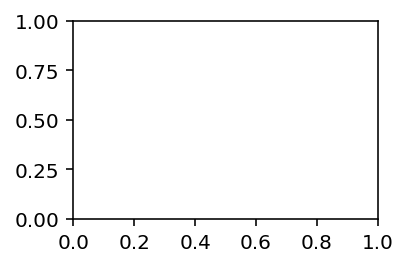

In [55]:
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"""
    train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores = 1 - train_scores
    test_scores = 1 - test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.semilogx(train_sizes, train_scores_mean, ".-", color="r",
             label="Training error")
    plt.semilogx(train_sizes, test_scores_mean, ".-", color="g",
             label="Test error")

cross_validation_generator = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=0.3)

cc = [ 0.001, 1, 10, 1000 ]

for i, C in enumerate(cc):
    plt.subplot(2, 2, i + 1)
    size_classifier.set_params(C=C)
    plot_learning_curve(size_classifier, X, y, cv=cross_validation_generator, n_jobs=-1,
        train_sizes=np.logspace(start=-2, stop=0, num=20, base=10))
    if i == 0:
        plt.legend()
    plt.grid()
    plt.ylabel("error")
    plt.xlabel("$m$")
    plt.title("$C$ = %g" % C)

plt.tight_layout()
plt.show()

In [54]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)

# Fork on GitHub!

<img src="qr-code-to-github-repo.svg" />

<center>https://github.com/NIPE-SYSTEMS/support-vector-machine</center>